1\. **Kernel Density Estimate**

Produce a KDE for a given distribution (by hand, not using seaborn!):

* Fill a numpy array, x,  of len(N) (with N=O(100)) with a variable normally distributed, with a given mean a standard deviation
* Fill an histogram in pyplot taking properly care about the aesthetic
   * use a meaningful number of bins
   * set a proper y axis label
   * set proper value of y axis major ticks labels (e.g. you want to display only integer labels)
   * display the histograms as data points with errors (the error being the poisson uncertainty)
* for every element of x, create a gaussian with the mean corresponding the element value and std as a parameter that can be tuned. The std default value should be:
$$ 1.06 * x.std() * x.size ^{-\frac{1}{5.}} $$
you can use the scipy function `stats.norm()` for that.
* In a separate plot (to be placed beside the original histogram), plot all the gaussian functions so obtained
* Sum (with np.sum()) all the gaussian functions and normalize the result such that the integral matches the integral of the original histogram. For that you could use the `scipy.integrate.trapz()` method


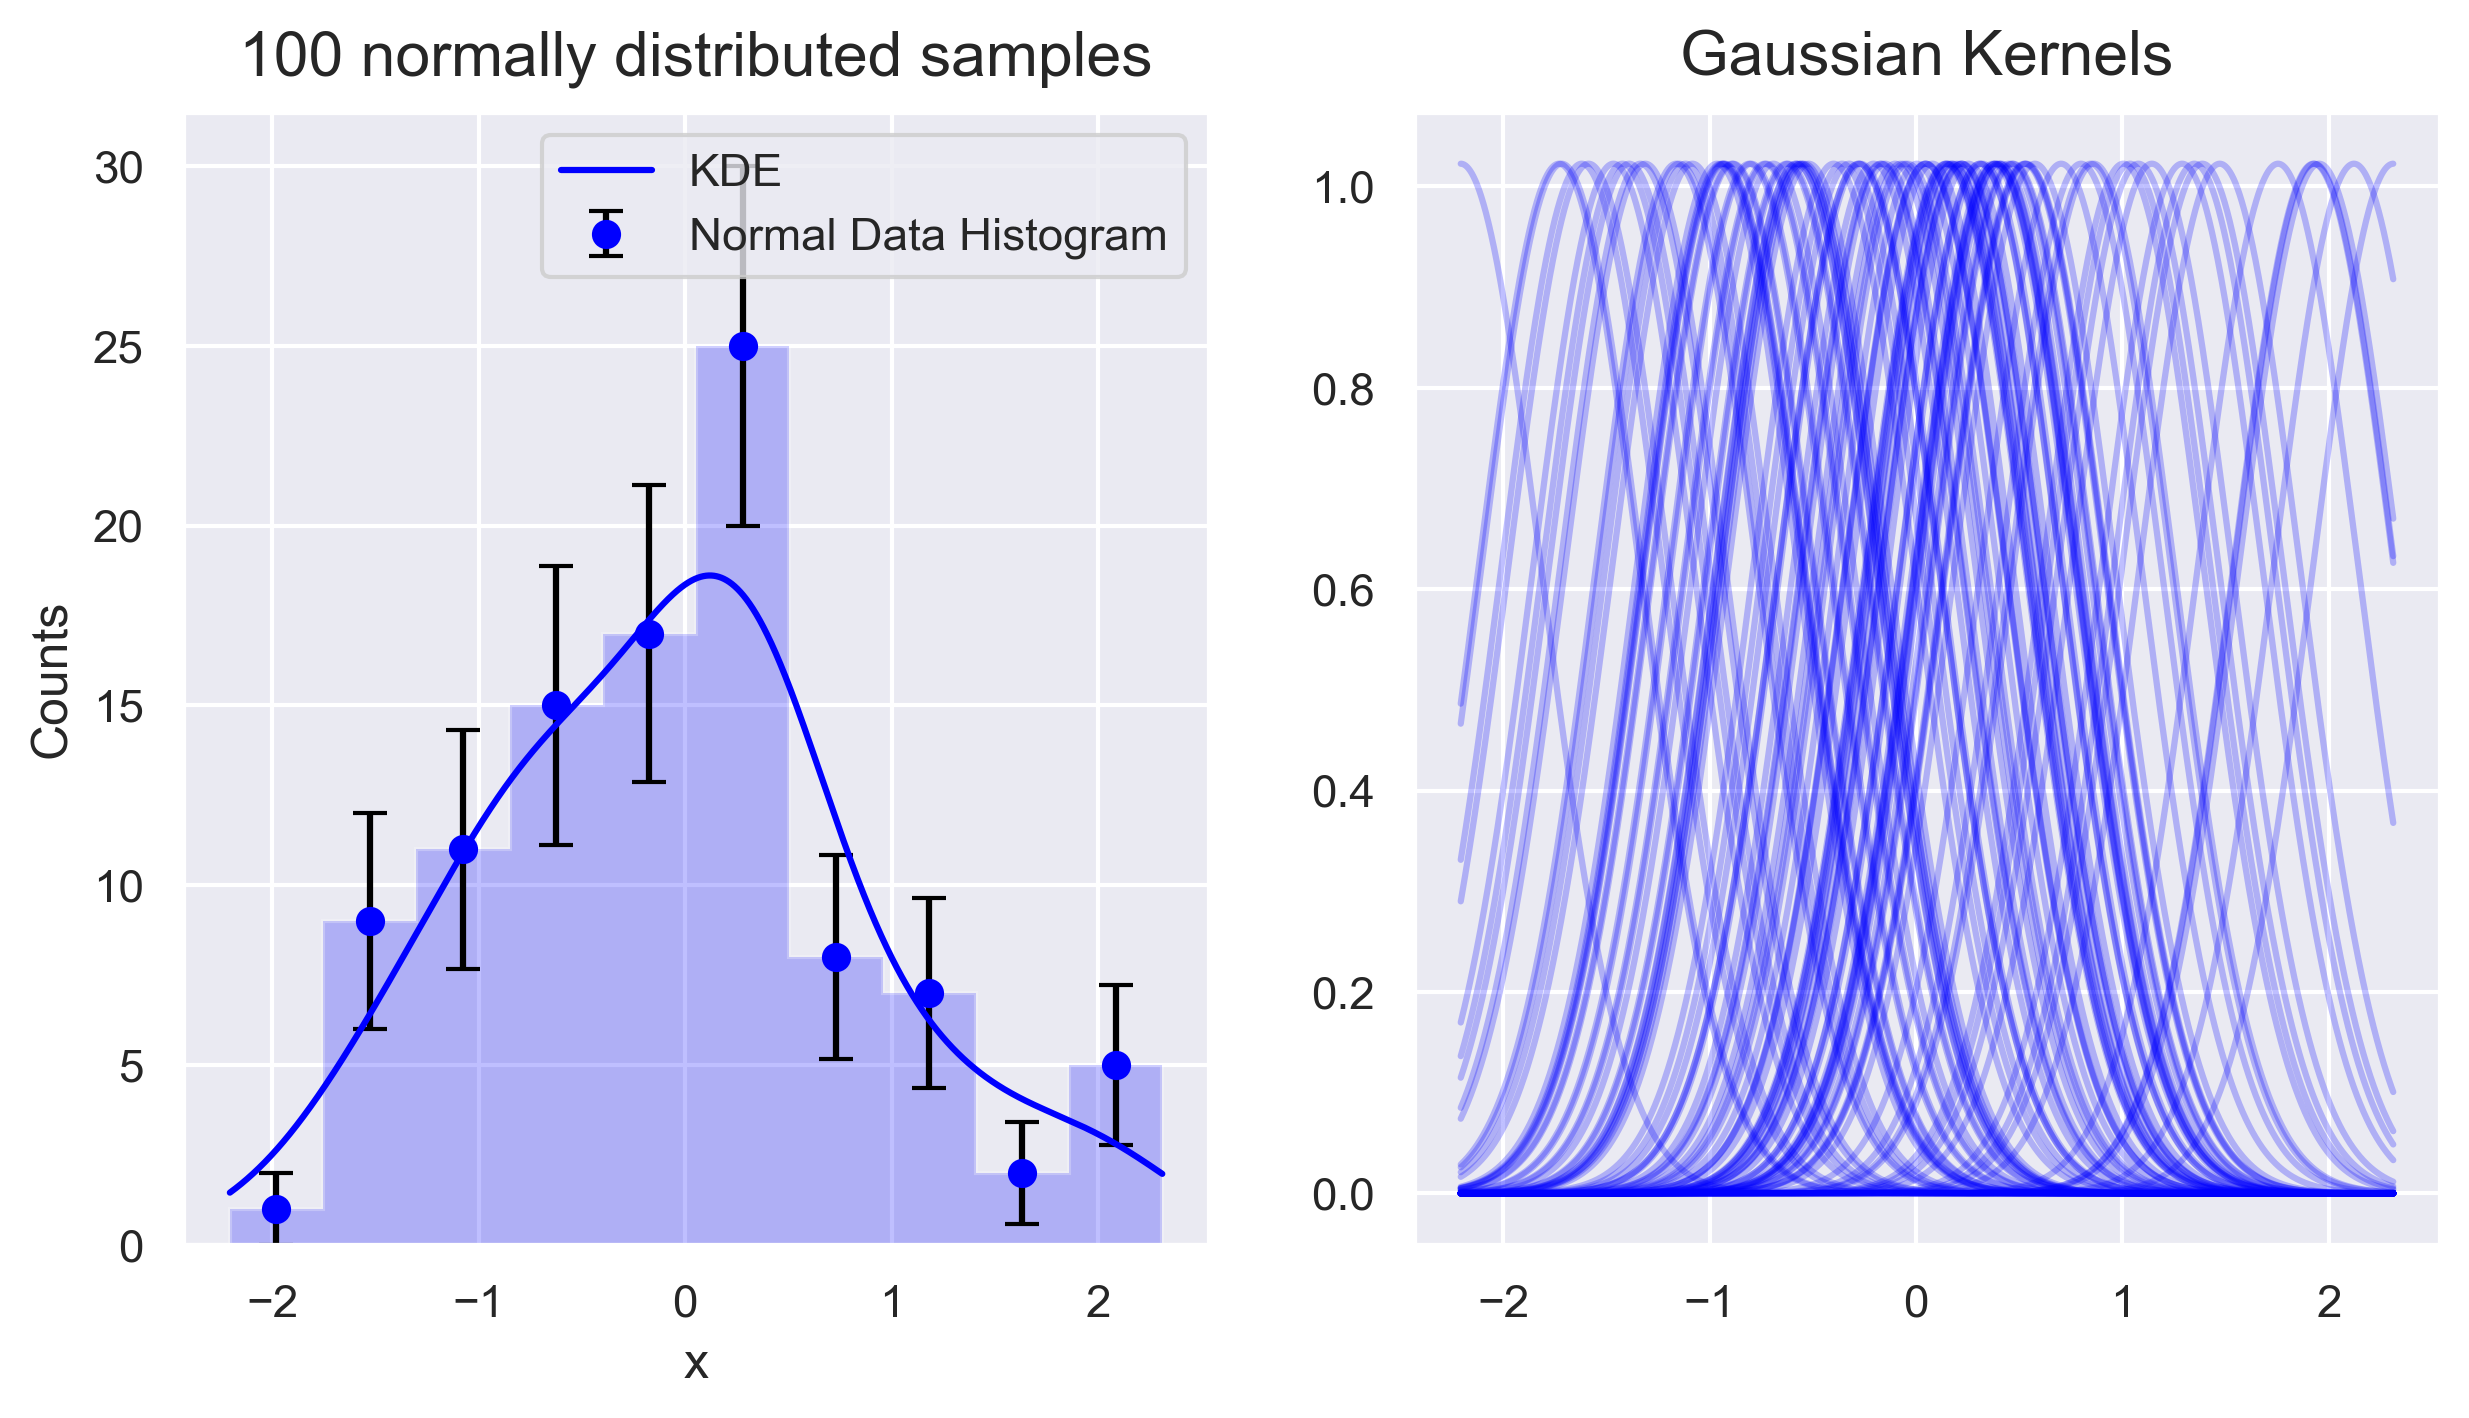

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.integrate import trapz 
normal=np.random.normal(scale=1, size=100)
bins=int(len(normal)/10)

def default(x):
    return 1.06*x.std()*(x.size)**(-1/5)


fig = plt.figure(figsize=(15, 5), dpi=300)
ax1 = fig.add_subplot(131)
y=ax1.hist(normal, bins=bins,histtype='stepfilled', color='blue', alpha=0.25)
xbin=[(y[1][i]+y[1][i+1])/2 for i in range(len(y[1])-1)]
plt.errorbar(xbin, y[0], yerr=np.sqrt(y[0]), fmt='o', color="blue",ecolor="black", capsize=4, label="Normal Data Histogram")
ax1.set_title("100 normally distributed samples", fontsize=15, verticalalignment='bottom')
ax1.set_xlabel("x")
ax1.set_ylabel("Counts")
ax1.tick_params(axis='x' ,which='major', width=0.5)
ax1.tick_params(axis='y' ,which='major', width=1)


ax2 = fig.add_subplot(132)
ax2.set_title("Gaussian Kernels", fontsize=15, verticalalignment='bottom')

x = np.arange(min(normal), max(normal), 1e-3)
sum=0
for n in normal:
    temp= stats.norm.pdf(x, n, default(normal))
    ax2.plot(x, temp, color='blue', alpha=0.25)

    sum+=temp
area=trapz(y[0],xbin)
gaussain=sum/len(normal)*area
ax1.plot(x, gaussain, color="blue", label="KDE")
ax1.legend()
plt.show()

2\. **Color-coded scatter plot**

Produce a scatter plot out of a dataset with two categories

* Write a function that generate a 2D datasets of 2 categories. Each category should distribute as a 2D gaussian with a given mean and std (clearly it is better to have different values means..)
* Display the dataset in a scatter plot marking the two categories with different marker colors.

An example is given below

You can try to make the procedure more general by allowing a given number $n\ge 2$ of categories

--2021-12-07 10:46:00--  https://www.dropbox.com/s/u4y3k4kk5tc7j46/two_categories_scatter_plot.png
Resolving www.dropbox.com (www.dropbox.com)... 162.125.69.18
Connecting to www.dropbox.com (www.dropbox.com)|162.125.69.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/u4y3k4kk5tc7j46/two_categories_scatter_plot.png [following]
--2021-12-07 10:46:00--  https://www.dropbox.com/s/raw/u4y3k4kk5tc7j46/two_categories_scatter_plot.png
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc2fd61df18667e8626faaa6cae4.dl.dropboxusercontent.com/cd/0/inline/BbbC1Hnvx_PDTYQJBpq7kofRytw0d0Ia5zV6v1udUWqpQW-ATv3cnfWnBryV4DkFseLVKQiR5OFOLbwxqieqi1AZqYq1B1SpGjYhx0ndmXe0yQ4TnZLP33jnqG65m06jnQOS0299UPvzwt07s8IfSOzs/file# [following]
--2021-12-07 10:46:00--  https://uc2fd61df18667e8626faaa6cae4.dl.dropboxusercontent.com/cd/0/inline/BbbC1Hnvx_PDTYQJBpq7kofRytw0d0Ia5zV6v1udUWqpQW-ATv3cnfWnBry

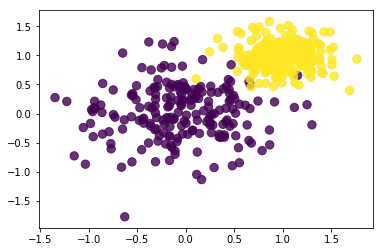

In [5]:
! wget https://www.dropbox.com/s/u4y3k4kk5tc7j46/two_categories_scatter_plot.png
from IPython.display import Image
Image('two_categories_scatter_plot.png')

Text(0, 0.5, 'Counts')

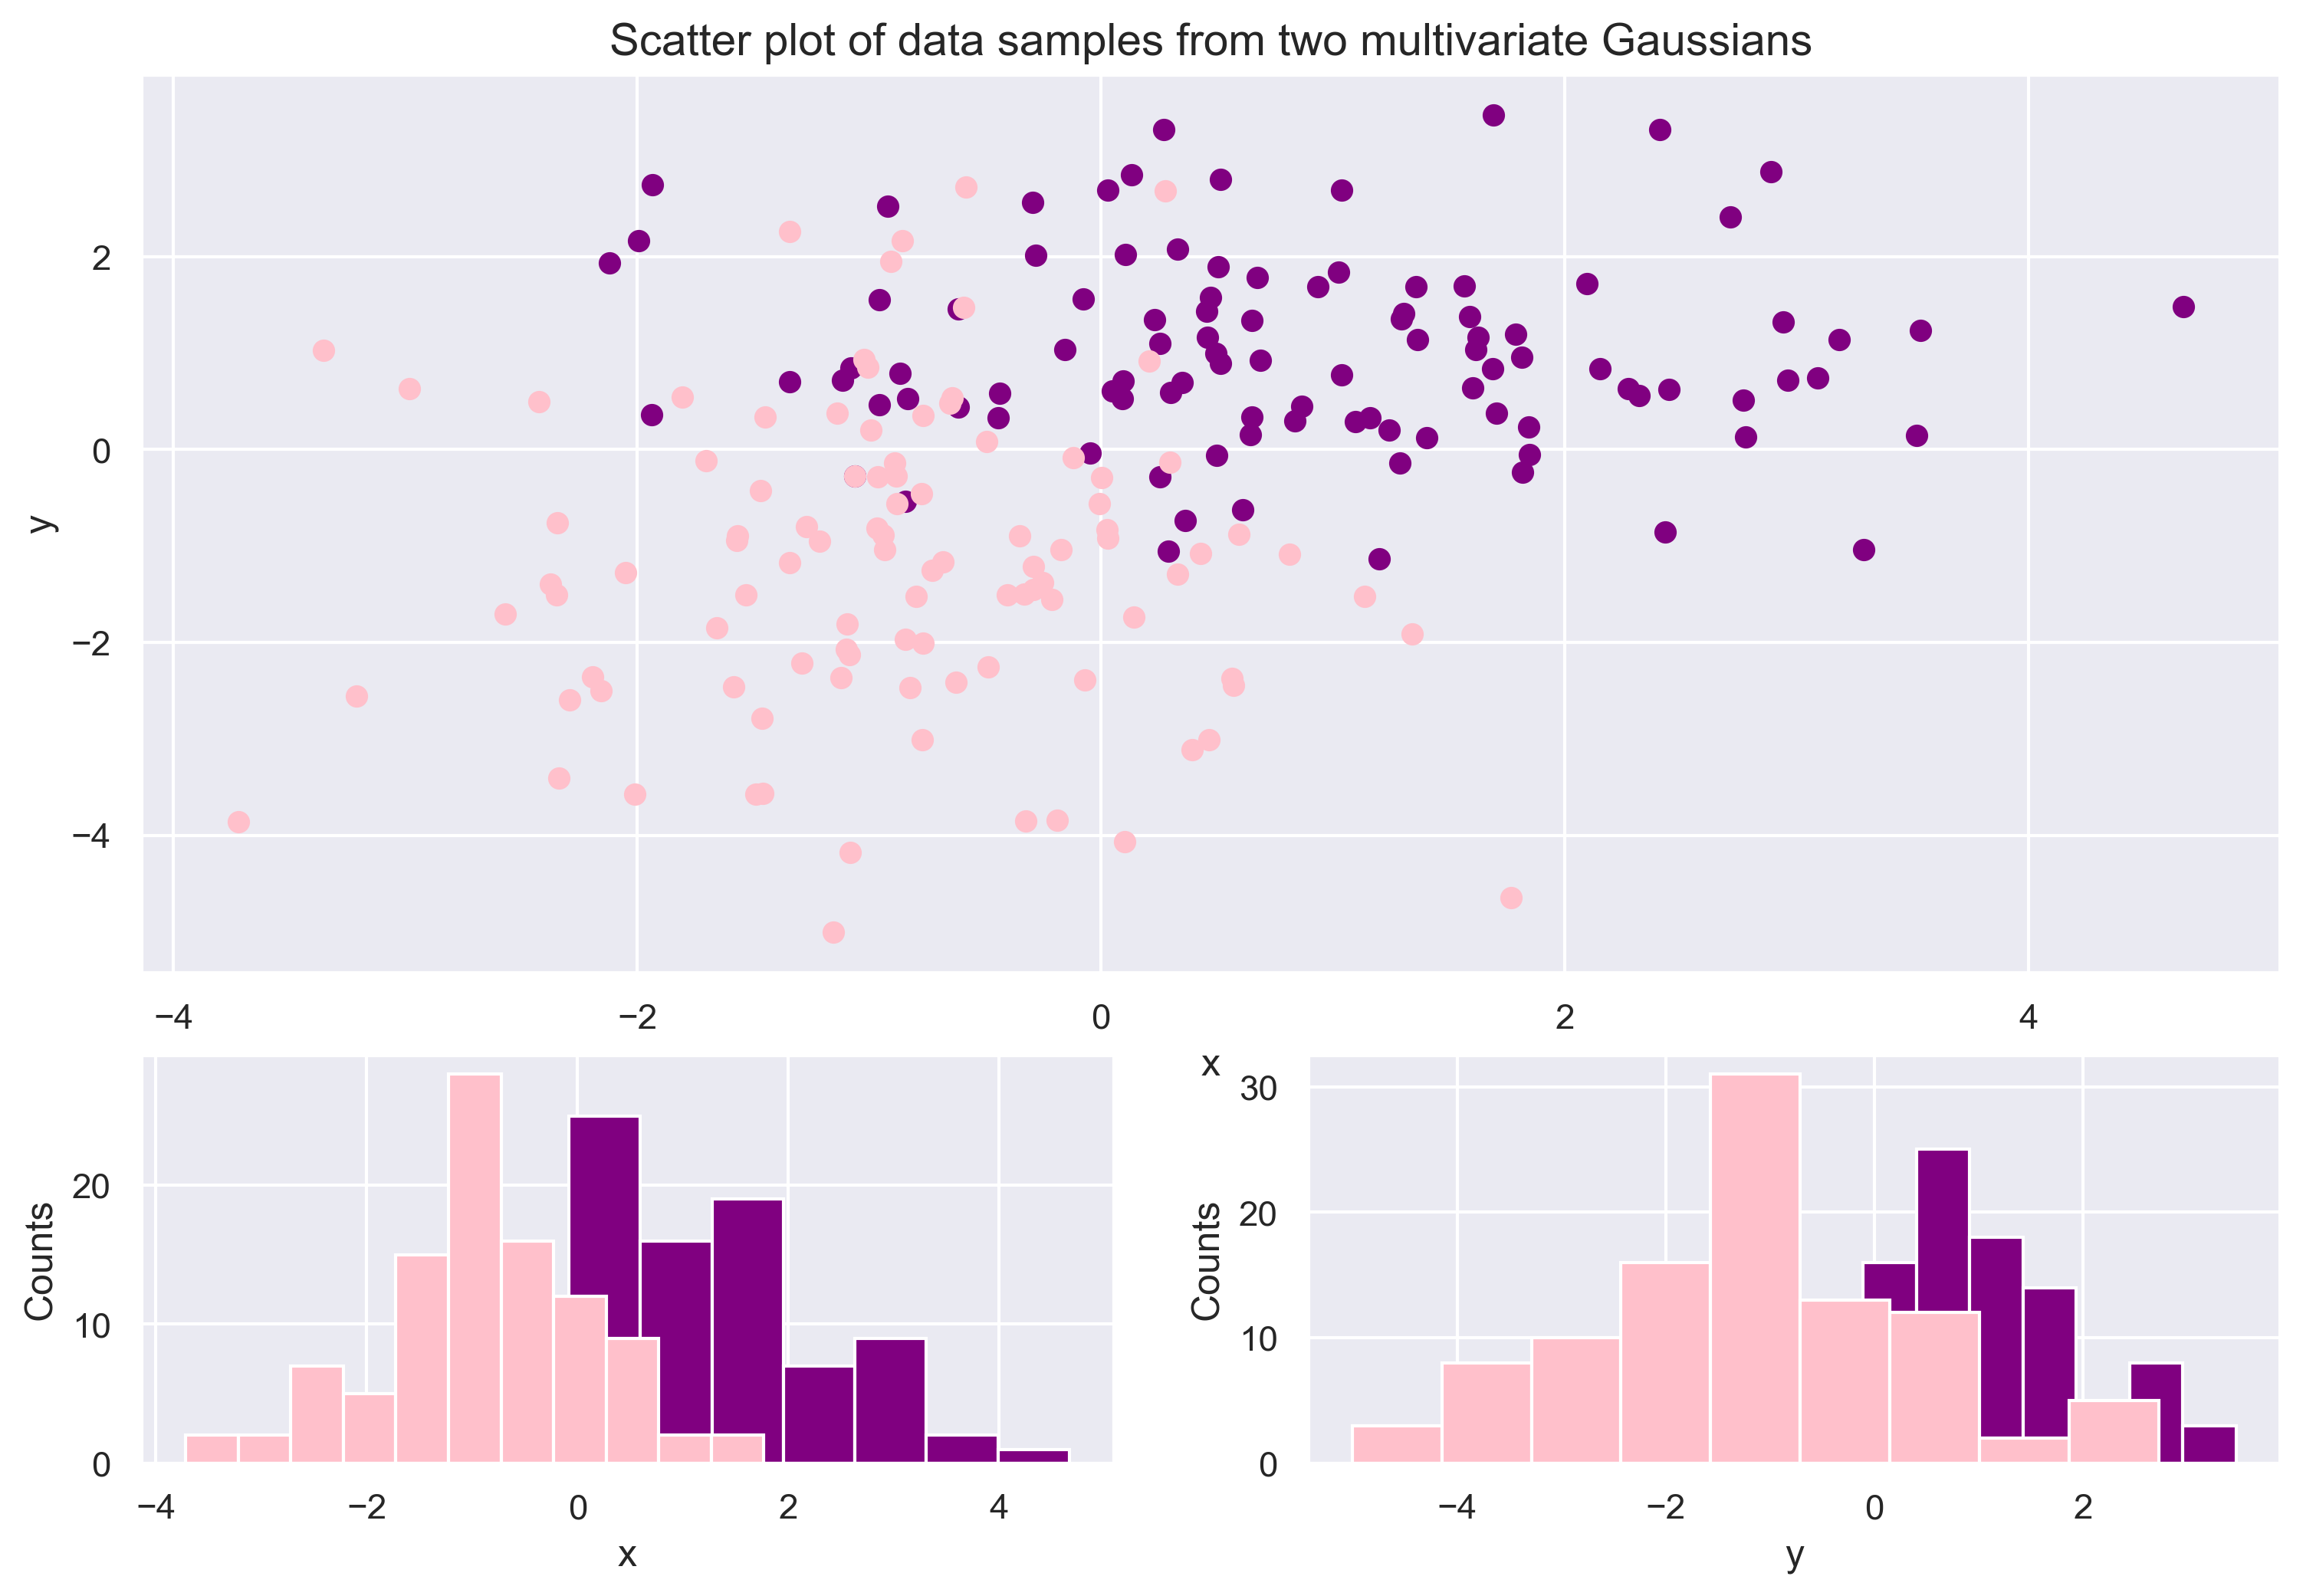

In [6]:
def datagen(mean, sigma, size):
    return np.random.multivariate_normal(mean=mean, cov=sigma, size=size)

data1= datagen([1,1], np.diag([2,1]), 100)
data2= datagen([-1,-1], np.diag([1,3]), 100)



gridsize = (3, 2)
fig = plt.figure(figsize=(12, 8), dpi=300)

ax1 = plt.subplot2grid(gridsize, (0, 0), colspan=2, rowspan=2)
ax1.scatter(x=data1.T[0], y=data1.T[1], c="purple")
ax1.scatter(x=data2.T[0], y=data2.T[1], c="pink")
ax1.set_xlabel("x")
ax1.set_ylabel("y")
ax1.set_title('Scatter plot of data samples from two multivariate Gaussians', fontsize=14)

ax2 = plt.subplot2grid(gridsize, (2, 0))
ax2.hist(data1.T[0], bins='auto', color="purple")
ax2.hist(data2.T[0], bins='auto', color="pink")
ax2.set_xlabel("x")
ax2.set_ylabel("Counts")

ax3 = plt.subplot2grid(gridsize, (2, 1))
ax3.hist(data1.T[1], bins='auto', color="purple")
ax3.hist(data2.T[1], bins='auto', color="pink")
ax3.set_xlabel("y")
ax3.set_ylabel("Counts")


3\. **Profile plot**

Produce a profile plot from a scatter plot.
* Download the following dataset and load it as a pandas dataframe:
```bash
wget https://www.dropbox.com/s/hgnvyj9abatk8g6/residuals_261.npy
```
Note that you should use the `np.load()` function to load the file as a numpy array, call the `.item()` method, and then pass it to the `pd.DataFrame()` constructor.
* Inspect the dataset, you'll find two variables (features)
* Clean the sample by selecting the entries (rows) with the variable "residual" in absolute value smaller than 2
* perform a linear regression of "residuals" versus "distances" using `scipy.stats.linregress()` 
* plot a seaborn jointplot of  "residuals" versus "distances", having seaborn performing a linear regression. The result of the regression should be displayed on the plot
* Fill 3 numpy arrays
  * x, serving as an array of bin centers for the "distance" variable. It should range from 0 to 20 with reasonable number of steps (bins)
  * y, the mean values of the "residuals", estimated in slices (bins) of "distance"
  * erry, the standard deviation of the  of the "residuals", estimated in slices (bins) of "distance"
* Plot the profile plot on top of the scatter plot

In [7]:
import pandas as pd
!wget https://www.dropbox.com/s/hgnvyj9abatk8g6/residuals_261.npy -P ~/data/

--2021-12-07 10:46:02--  https://www.dropbox.com/s/hgnvyj9abatk8g6/residuals_261.npy
Resolving www.dropbox.com (www.dropbox.com)... 162.125.69.18
Connecting to www.dropbox.com (www.dropbox.com)|162.125.69.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/hgnvyj9abatk8g6/residuals_261.npy [following]
--2021-12-07 10:46:02--  https://www.dropbox.com/s/raw/hgnvyj9abatk8g6/residuals_261.npy
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc18268ee11bc020cb0286e8b310.dl.dropboxusercontent.com/cd/0/inline/BbYl4VyuM90zX_AeNr7FEJN8to-0_xWDn7v3CmZ_h1oKj9hnqMJitqH7Tq_qiC-zErDGAM2Ag9peS4CLvk3AcsJl97yQU0OqRIWkf9cFbv_chTOegQduTecesRh5EUKDUIj-NM854bHtrukycwiCB0qP/file# [following]
--2021-12-07 10:46:02--  https://uc18268ee11bc020cb0286e8b310.dl.dropboxusercontent.com/cd/0/inline/BbYl4VyuM90zX_AeNr7FEJN8to-0_xWDn7v3CmZ_h1oKj9hnqMJitqH7Tq_qiC-zErDGAM2Ag9peS4CLvk3AcsJl97yQU0OqRIWkf

In [8]:
file_name = "/Users/alessiogiorlandino/data/residuals_261.npy"
data=np.load(file_name, allow_pickle=True)
df=pd.DataFrame(data.item())
df.describe()

,residuals,distances
count,11131.000000,11131.000000
mean,-0.616477,9.771465
std,4.163705,5.877819
min,-160.850000,0.000000
25%,-0.330000,4.400000
50%,-0.110000,9.700000
75%,0.060000,14.900000
max,11.320000,24.900000


* Fill 3 numpy arrays
  * x, serving as an array of bin centers for the "distance" variable. It should range from 0 to 20 with reasonable number of steps (bins)
  * y, the mean values of the "residuals", estimated in slices (bins) of "distance"
  * erry, the standard deviation of the  of the "residuals", estimated in slices (bins) of "distance"
* Plot the profile plot on top of the scatter plot

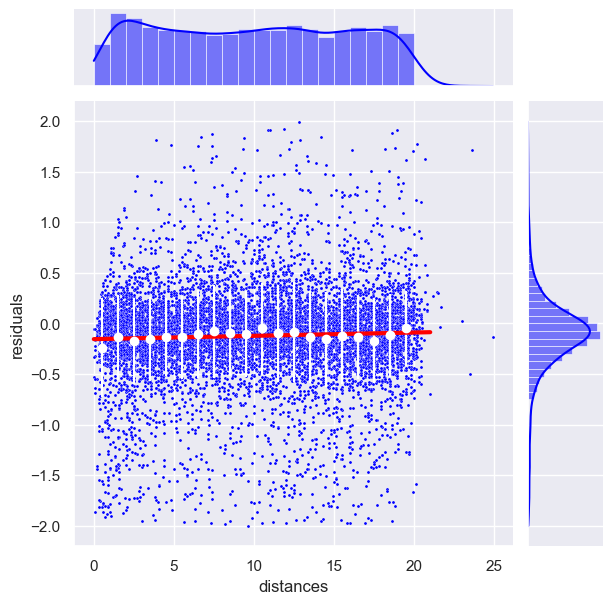

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(rc={"figure.dpi":100, 'savefig.dpi':300})
joint_plot = sns.JointGrid()
sns.scatterplot(x=df["distances"], y=df["residuals"], color="blue", ax=joint_plot.ax_joint, linewidth=0.2, s=5)
sns.histplot(x=df["distances"], ax=joint_plot.ax_marg_x, color="blue", bins=20, binrange=(0, 20), linewidth=0.4, kde=True)
sns.histplot(y=df["residuals"], ax=joint_plot.ax_marg_y, color="blue", bins=20, binrange=(-.75, .75), linewidth=0.4, kde=True)

param= stats.linregress(df["distances"], df["residuals"])
joint_plot.ax_joint.plot(np.linspace(0, 21, 1000), param[1] + param[0] * np.linspace(0, 21, 1000), color="red", linewidth=3)

x = np.arange(0, 21, 1)
y = df.groupby(pd.cut(df["distances"], bins = x)).mean()["residuals"]
sigma = df.groupby(pd.cut(df["distances"], bins = x)).std()["residuals"] 
joint_plot.ax_joint.errorbar((x[1:] + x[:-1]) / 2, y, yerr=sigma, fmt="o", color="white")

plt.xlabel("distances")
plt.ylabel("residual")
plt.show()